# 01. 회귀 모델 (Regression Models)

---

## 목차 / Table of Contents
1. 데이터 준비 / Data Preparation
2. Linear Regression (선형 회귀)
3. Ridge Regression (릿지 회귀)
4. Lasso Regression (라쏘 회귀)
5. Random Forest Regressor
6. XGBoost Regressor
7. 모델 비교 / Model Comparison
8. 하이퍼파라미터 튜닝 / Hyperparameter Tuning
9. 피처 중요도 / Feature Importance

In [1]:
# ============================================================
# 라이브러리 임포트 / Library Imports
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 사이킷런 / Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XGBoost
from xgboost import XGBRegressor

# 설정 / Settings
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')

print("✅ 라이브러리 로드 완료 / Libraries loaded")

✅ 라이브러리 로드 완료 / Libraries loaded


---
## 1. 데이터 준비 / Data Preparation

In [2]:
# ============================================================
# 토이 데이터 생성 / Create Toy Data
# ============================================================

def create_regression_data(n_samples=1000, n_features=10, noise=0.1, random_state=42):
    """
    회귀 문제용 토이 데이터 생성
    Create toy data for regression
    """
    np.random.seed(random_state)
    
    # 피처 생성 / Generate features
    X = np.random.randn(n_samples, n_features)
    
    # 일부 피처만 중요하도록 설정 / Only some features are important
    coefficients = np.zeros(n_features)
    coefficients[:5] = [3.0, -2.0, 1.5, -1.0, 0.5]  # 처음 5개만 중요
    
    # 비선형성 추가 / Add non-linearity
    y = X @ coefficients + 0.5 * X[:, 0]**2 + noise * np.random.randn(n_samples)
    
    # DataFrame 생성 / Create DataFrame
    feature_names = [f'feature_{i}' for i in range(n_features)]
    df = pd.DataFrame(X, columns=feature_names)
    df['target'] = y
    
    return df

# 데이터 생성 / Generate data
df = create_regression_data(n_samples=1000, n_features=10)
print(f"데이터 shape: {df.shape}")
print(f"\n기본 통계:")
df.describe()

데이터 shape: (1000, 11)

기본 통계:


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.010788,0.031292,-0.022542,-0.043075,0.013622,-0.029252,-0.002689,0.005495,-0.023104,0.038105,0.486861
std,1.005433,1.016046,0.983366,0.983406,1.012645,1.037024,1.031230,1.030962,0.986846,0.945284,4.056433
min,-3.922400,-3.688365,-3.241267,-2.943142,-3.138515,-3.170426,-2.801912,-3.601085,-3.007632,-3.176704,-9.329030
25%,-0.616527,-0.631506,-0.702626,-0.750008,-0.651541,-0.749592,-0.744779,-0.713176,-0.650034,-0.559290,-2.283282
50%,0.014006,0.007605,-0.015036,-0.001346,-0.012020,-0.012086,-0.024976,-0.013284,-0.003221,0.019097,0.215587
75%,0.679698,0.685621,0.613766,0.638310,0.721896,0.680087,0.683319,0.696602,0.608861,0.687027,2.957241
max,3.076860,3.529055,3.152057,3.117681,2.935658,3.926238,3.243093,3.137749,3.377383,3.852731,15.899569


In [3]:
# ============================================================
# 데이터 분할 및 스케일링 / Split and Scale Data
# ============================================================

# 피처와 타겟 분리 / Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Train/Test 분할 / Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# 스케일링 / Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"훈련 세트: {X_train.shape}")
print(f"테스트 세트: {X_test.shape}")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

훈련 세트: (800, 10)
테스트 세트: (200, 10)
Training set: (800, 10)
Test set: (200, 10)


In [4]:
# ============================================================
# 평가 함수 정의 / Define Evaluation Function
# ============================================================

def evaluate_regression(y_true, y_pred, model_name='Model'):
    """
    회귀 모델 평가
    Evaluate regression model
    
    평가 지표 / Metrics:
    - MAE (Mean Absolute Error): 평균 절대 오차 - 해석이 쉬움
    - RMSE (Root Mean Squared Error): 평균 제곱근 오차 - 큰 오차에 패널티
    - R² (R-squared): 결정 계수 - 설명력 (1에 가까울수록 좋음)
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{'='*50}")
    print(f"📊 {model_name} 평가 결과 / Evaluation Results")
    print(f"{'='*50}")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")
    
    return {'mae': mae, 'rmse': rmse, 'r2': r2}

def plot_predictions(y_true, y_pred, model_name='Model'):
    """
    예측값 vs 실제값 시각화
    Visualize predictions vs actual values
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 산점도 / Scatter plot
    axes[0].scatter(y_true, y_pred, alpha=0.5)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0].set_xlabel('Actual / 실제값')
    axes[0].set_ylabel('Predicted / 예측값')
    axes[0].set_title(f'{model_name}: Actual vs Predicted')
    
    # 잔차 분포 / Residual distribution
    residuals = y_true - y_pred
    axes[1].hist(residuals, bins=30, edgecolor='black')
    axes[1].axvline(0, color='r', linestyle='--')
    axes[1].set_xlabel('Residual / 잔차')
    axes[1].set_ylabel('Frequency / 빈도')
    axes[1].set_title(f'{model_name}: Residual Distribution')
    
    plt.tight_layout()
    plt.show()

---
## 2. Linear Regression (선형 회귀)

**특징 / Characteristics:**
- 가장 기본적인 회귀 모델 / Most basic regression model
- 빠르고 해석이 쉬움 / Fast and interpretable
- 과적합에 취약 / Prone to overfitting


📊 Linear Regression 평가 결과 / Evaluation Results
MAE:  0.5859
RMSE: 1.0390
R²:   0.9435


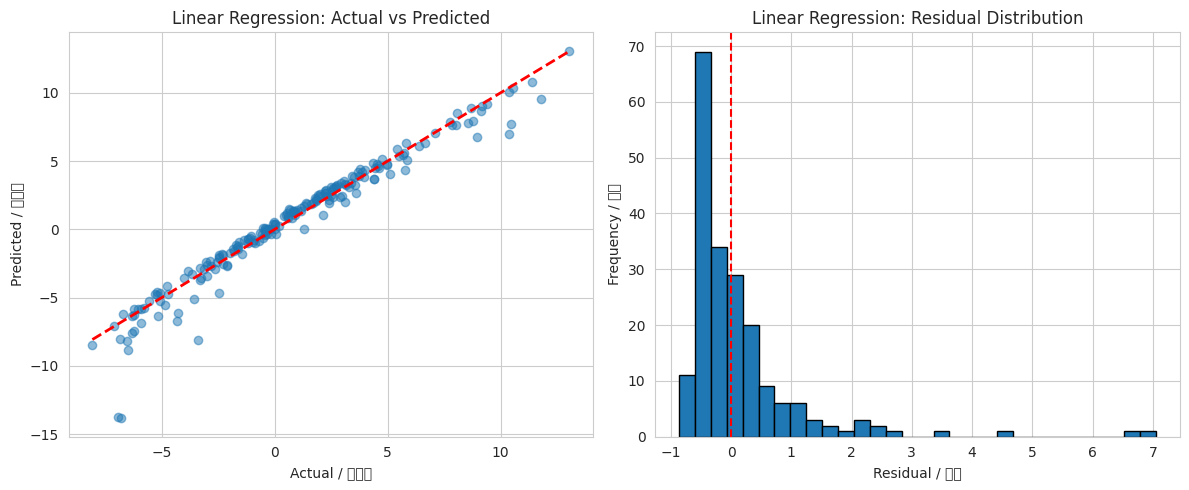

In [5]:
# ============================================================
# Linear Regression / 선형 회귀
# ============================================================

# 모델 생성 및 학습 / Create and train model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# 예측 / Predict
y_pred_lr = lr_model.predict(X_test_scaled)

# 평가 / Evaluate
lr_results = evaluate_regression(y_test, y_pred_lr, 'Linear Regression')

# 시각화 / Visualize
plot_predictions(y_test, y_pred_lr, 'Linear Regression')


피처별 계수 (절대값 기준 정렬) / Coefficients (sorted by absolute value):
     feature  coefficient
0  feature_0     2.940099
1  feature_1    -1.987326
2  feature_2     1.438110
3  feature_3    -0.997433
4  feature_4     0.489626
9  feature_9     0.039786
8  feature_8     0.039344
7  feature_7     0.013674
5  feature_5    -0.006641
6  feature_6     0.002330


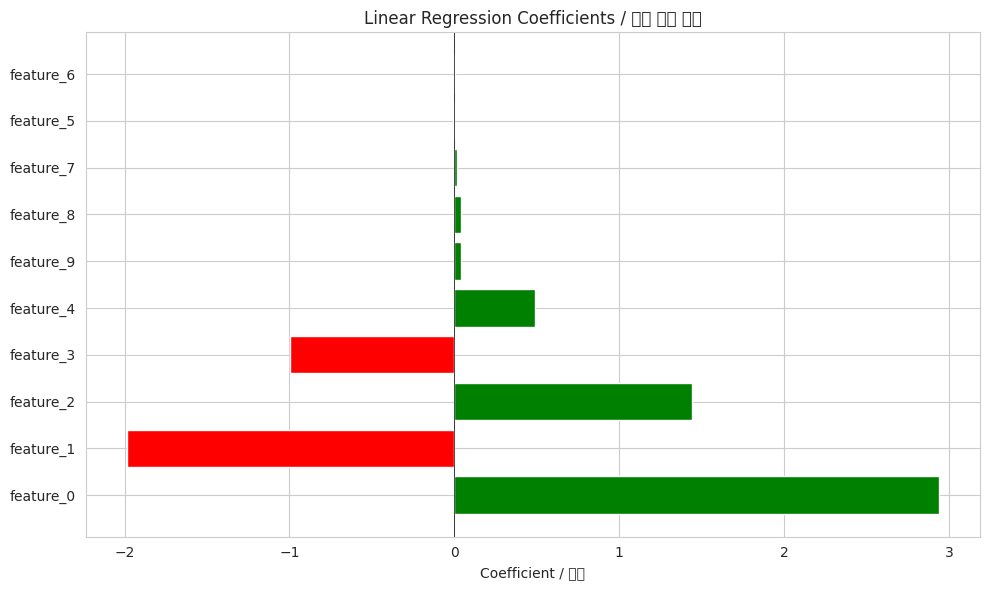

In [6]:
# ============================================================
# 선형 회귀 계수 해석 / Linear Regression Coefficients
# ============================================================

# 계수 확인 / Check coefficients
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print("\n피처별 계수 (절대값 기준 정렬) / Coefficients (sorted by absolute value):")
print(coef_df)

# 시각화 / Visualize
plt.figure(figsize=(10, 6))
colors = ['green' if c > 0 else 'red' for c in coef_df['coefficient']]
plt.barh(coef_df['feature'], coef_df['coefficient'], color=colors)
plt.xlabel('Coefficient / 계수')
plt.title('Linear Regression Coefficients / 선형 회귀 계수')
plt.axvline(0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

---
## 3. Ridge Regression (릿지 회귀)

**특징 / Characteristics:**
- L2 정규화 사용 / Uses L2 regularization
- 모든 피처 유지 (계수를 작게 만듦) / Keeps all features (shrinks coefficients)
- 다중공선성 문제 완화 / Reduces multicollinearity issues
- alpha: 정규화 강도 (클수록 강한 정규화)


📊 Ridge Regression 평가 결과 / Evaluation Results
MAE:  0.5858
RMSE: 1.0374
R²:   0.9437


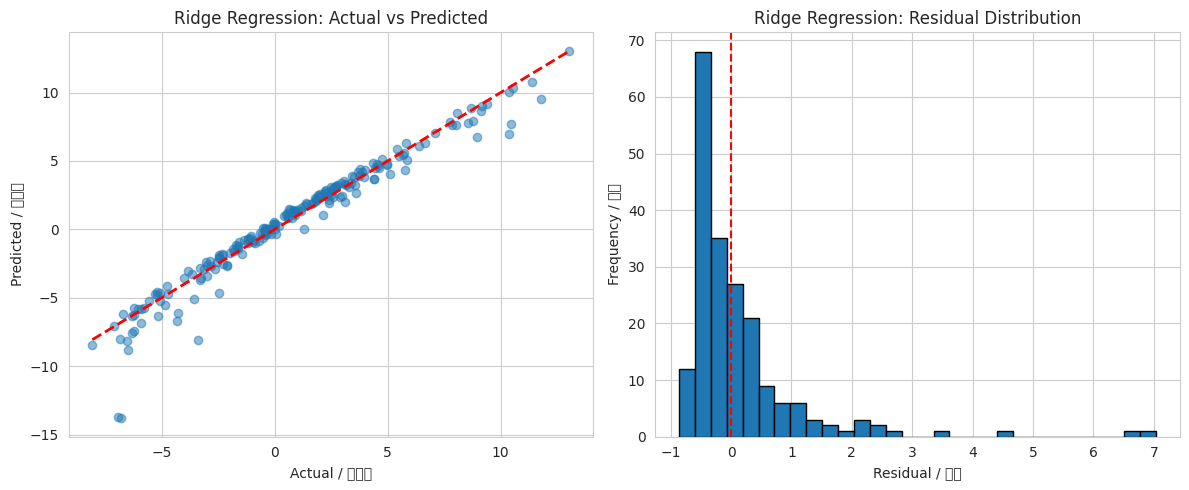

In [7]:
# ============================================================
# Ridge Regression / 릿지 회귀
# ============================================================

# 모델 생성 및 학습 / Create and train model
# alpha: 정규화 강도 (기본값=1.0)
ridge_model = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge_model.fit(X_train_scaled, y_train)

# 예측 / Predict
y_pred_ridge = ridge_model.predict(X_test_scaled)

# 평가 / Evaluate
ridge_results = evaluate_regression(y_test, y_pred_ridge, 'Ridge Regression')

# 시각화 / Visualize
plot_predictions(y_test, y_pred_ridge, 'Ridge Regression')

In [8]:
# ============================================================
# Ridge: 최적 alpha 찾기 / Find Optimal Alpha
# ============================================================

from sklearn.linear_model import RidgeCV

# 여러 alpha 값 테스트 / Test multiple alpha values
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train_scaled, y_train)

print(f"최적 alpha / Best alpha: {ridge_cv.alpha_}")

# 최적 alpha로 다시 평가 / Evaluate with best alpha
y_pred_ridge_cv = ridge_cv.predict(X_test_scaled)
evaluate_regression(y_test, y_pred_ridge_cv, 'Ridge (Optimal Alpha)')

최적 alpha / Best alpha: 1.0

📊 Ridge (Optimal Alpha) 평가 결과 / Evaluation Results
MAE:  0.5858
RMSE: 1.0374
R²:   0.9437


{'mae': 0.5858291324881729,
 'rmse': np.float64(1.0373904288376432),
 'r2': 0.9436894034572202}

---
## 4. Lasso Regression (라쏘 회귀)

**특징 / Characteristics:**
- L1 정규화 사용 / Uses L1 regularization
- 피처 선택 효과 (불필요한 피처 계수를 0으로) / Feature selection (sets unimportant coefficients to 0)
- alpha: 정규화 강도 (클수록 더 많은 피처가 0이 됨)

In [9]:
# ============================================================
# Lasso Regression / 라쏘 회귀
# ============================================================

# 모델 생성 및 학습 / Create and train model
lasso_model = Lasso(alpha=0.1, random_state=RANDOM_STATE, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)

# 예측 / Predict
y_pred_lasso = lasso_model.predict(X_test_scaled)

# 평가 / Evaluate
lasso_results = evaluate_regression(y_test, y_pred_lasso, 'Lasso Regression')

# 0이 된 계수 확인 (피처 선택 효과) / Check zero coefficients (feature selection)
zero_coefs = sum(lasso_model.coef_ == 0)
print(f"\n0이 된 피처 수: {zero_coefs} / {len(lasso_model.coef_)}")
print(f"Zero coefficients: {zero_coefs} / {len(lasso_model.coef_)}")


📊 Lasso Regression 평가 결과 / Evaluation Results
MAE:  0.6223
RMSE: 1.0148
R²:   0.9461

0이 된 피처 수: 5 / 10
Zero coefficients: 5 / 10


In [10]:
# ============================================================
# Lasso: 최적 alpha 찾기 / Find Optimal Alpha
# ============================================================

from sklearn.linear_model import LassoCV

# 여러 alpha 값 테스트 / Test multiple alpha values
lasso_cv = LassoCV(alphas=[0.001, 0.01, 0.1, 0.5, 1.0], cv=5, random_state=RANDOM_STATE, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)

print(f"최적 alpha / Best alpha: {lasso_cv.alpha_}")

# 최적 alpha로 다시 평가 / Evaluate with best alpha
y_pred_lasso_cv = lasso_cv.predict(X_test_scaled)
evaluate_regression(y_test, y_pred_lasso_cv, 'Lasso (Optimal Alpha)')

# 선택된 피처 / Selected features
selected_features = X.columns[lasso_cv.coef_ != 0].tolist()
print(f"\n선택된 피처 / Selected features: {selected_features}")

최적 alpha / Best alpha: 0.01

📊 Lasso (Optimal Alpha) 평가 결과 / Evaluation Results
MAE:  0.5877
RMSE: 1.0323
R²:   0.9442

선택된 피처 / Selected features: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_7', 'feature_8', 'feature_9']


---
## 5. Random Forest Regressor

**특징 / Characteristics:**
- 앙상블 학습 (여러 결정 트리 결합) / Ensemble learning (combines multiple decision trees)
- 비선형 관계 학습 가능 / Can learn non-linear relationships
- 과적합에 강건 / Robust to overfitting
- 피처 중요도 제공 / Provides feature importance


📊 Random Forest 평가 결과 / Evaluation Results
MAE:  0.9785
RMSE: 1.3156
R²:   0.9094


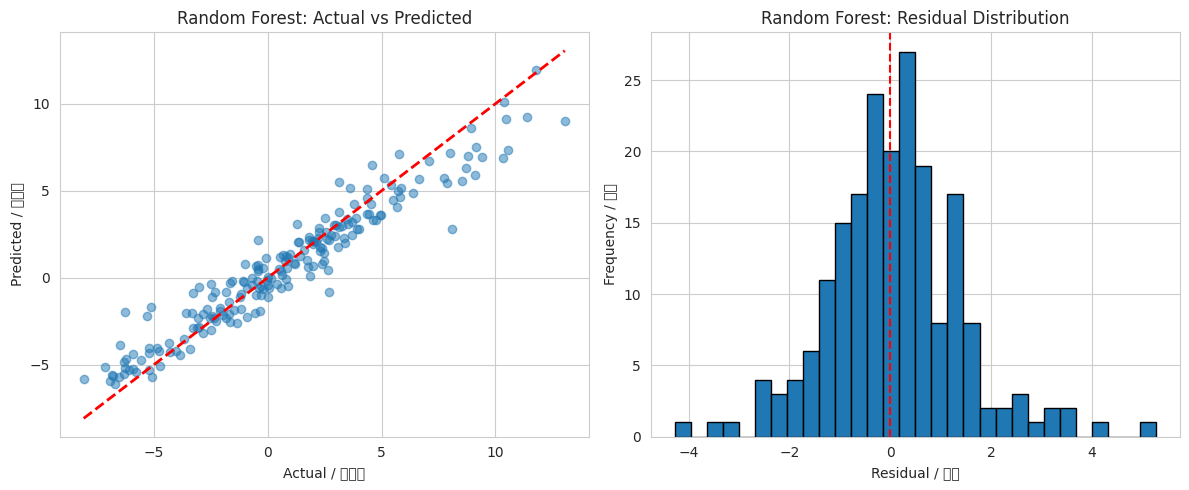

In [11]:
# ============================================================
# Random Forest Regressor / 랜덤 포레스트 회귀
# ============================================================

# 모델 생성 및 학습 / Create and train model
rf_model = RandomForestRegressor(
    n_estimators=100,      # 트리 개수 / Number of trees
    max_depth=10,          # 최대 깊이 / Maximum depth
    min_samples_split=5,   # 분할을 위한 최소 샘플 수 / Min samples to split
    min_samples_leaf=2,    # 리프 노드 최소 샘플 수 / Min samples in leaf
    random_state=RANDOM_STATE,
    n_jobs=-1              # 병렬 처리 / Parallel processing
)

# ⚠️ Random Forest는 스케일링 불필요 / RF doesn't need scaling
rf_model.fit(X_train, y_train)

# 예측 / Predict
y_pred_rf = rf_model.predict(X_test)

# 평가 / Evaluate
rf_results = evaluate_regression(y_test, y_pred_rf, 'Random Forest')

# 시각화 / Visualize
plot_predictions(y_test, y_pred_rf, 'Random Forest')

피처 중요도 / Feature Importance:
     feature  importance
0  feature_0    0.576479
1  feature_1    0.212442
2  feature_2    0.136272
3  feature_3    0.038685
4  feature_4    0.010729
7  feature_7    0.006731
6  feature_6    0.005408
8  feature_8    0.004568
5  feature_5    0.004365
9  feature_9    0.004322


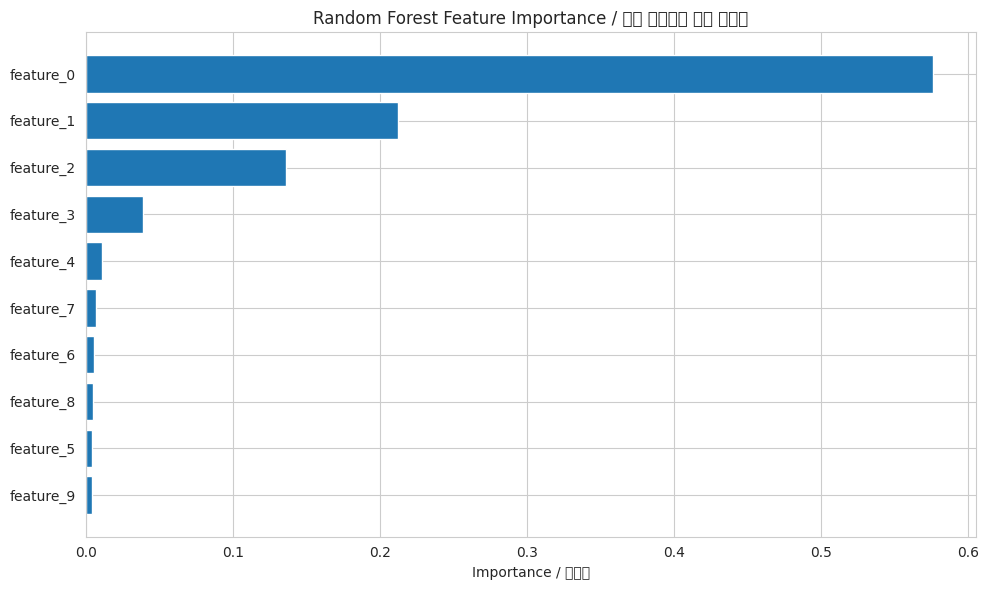

In [12]:
# ============================================================
# Random Forest: 피처 중요도 / Feature Importance
# ============================================================

# 피처 중요도 추출 / Extract feature importance
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("피처 중요도 / Feature Importance:")
print(importance_df)

# 시각화 / Visualize
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance / 중요도')
plt.title('Random Forest Feature Importance / 랜덤 포레스트 피처 중요도')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---
## 6. XGBoost Regressor

**특징 / Characteristics:**
- Gradient Boosting 기반 / Based on Gradient Boosting
- 높은 예측 성능 / High prediction performance
- 정규화 내장 / Built-in regularization
- 빠른 학습 속도 / Fast training


📊 XGBoost 평가 결과 / Evaluation Results
MAE:  0.7122
RMSE: 1.0259
R²:   0.9449


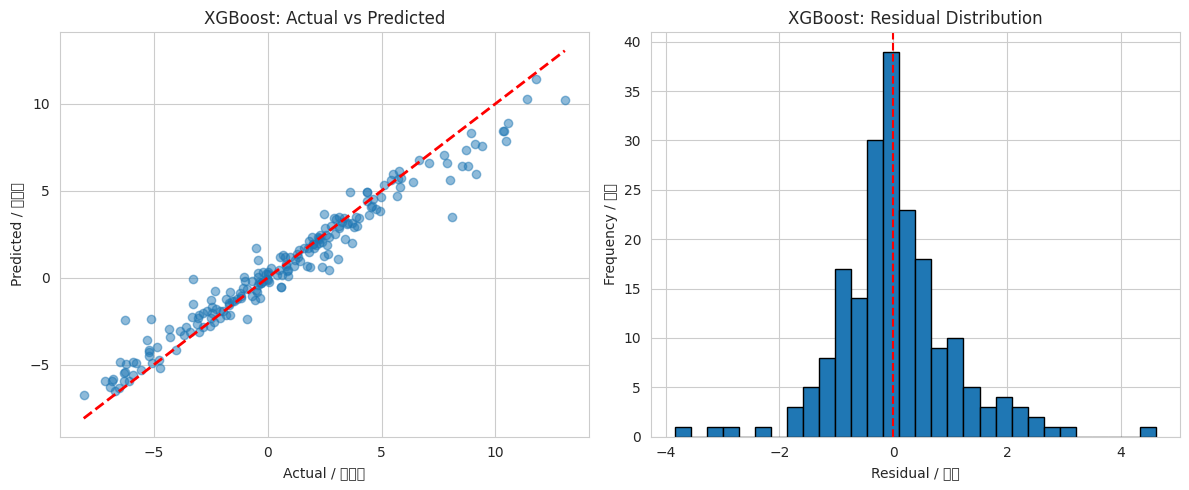

In [13]:
# ============================================================
# XGBoost Regressor / XGBoost 회귀
# ============================================================

# 모델 생성 및 학습 / Create and train model
xgb_model = XGBRegressor(
    n_estimators=100,      # 부스팅 라운드 수 / Number of boosting rounds
    max_depth=6,           # 최대 깊이 / Maximum depth
    learning_rate=0.1,     # 학습률 / Learning rate
    subsample=0.8,         # 샘플 비율 / Sample ratio
    colsample_bytree=0.8,  # 피처 비율 / Feature ratio
    reg_alpha=0.1,         # L1 정규화 / L1 regularization
    reg_lambda=1.0,        # L2 정규화 / L2 regularization
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# ⚠️ XGBoost도 스케일링 불필요 / XGBoost doesn't need scaling
xgb_model.fit(X_train, y_train)

# 예측 / Predict
y_pred_xgb = xgb_model.predict(X_test)

# 평가 / Evaluate
xgb_results = evaluate_regression(y_test, y_pred_xgb, 'XGBoost')

# 시각화 / Visualize
plot_predictions(y_test, y_pred_xgb, 'XGBoost')

XGBoost 피처 중요도 / XGBoost Feature Importance:
     feature  importance
0  feature_0    0.481047
1  feature_1    0.198342
2  feature_2    0.150082
3  feature_3    0.063039
4  feature_4    0.027516
7  feature_7    0.019470
5  feature_5    0.017883
9  feature_9    0.015810
8  feature_8    0.013860
6  feature_6    0.012951


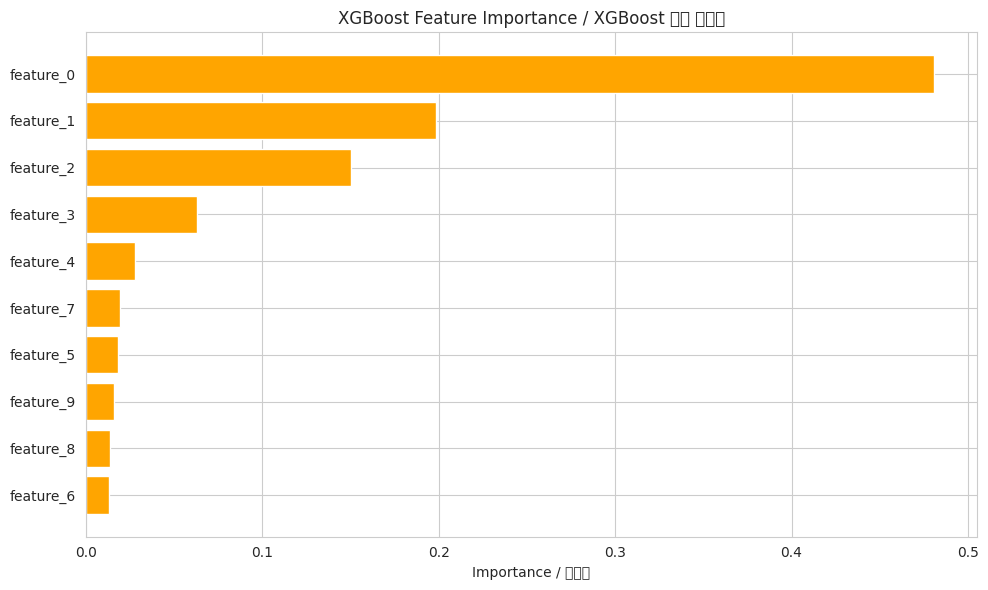

In [14]:
# ============================================================
# XGBoost: 피처 중요도 / Feature Importance
# ============================================================

# 피처 중요도 추출 / Extract feature importance
xgb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("XGBoost 피처 중요도 / XGBoost Feature Importance:")
print(xgb_importance)

# 시각화 / Visualize
plt.figure(figsize=(10, 6))
plt.barh(xgb_importance['feature'], xgb_importance['importance'], color='orange')
plt.xlabel('Importance / 중요도')
plt.title('XGBoost Feature Importance / XGBoost 피처 중요도')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---
## 7. 모델 비교 / Model Comparison

In [15]:
# ============================================================
# 모든 모델 비교 / Compare All Models
# ============================================================

# 결과 수집 / Collect results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Lasso', 'Random Forest', 'XGBoost'],
    'MAE': [lr_results['mae'], ridge_results['mae'], lasso_results['mae'], 
            rf_results['mae'], xgb_results['mae']],
    'RMSE': [lr_results['rmse'], ridge_results['rmse'], lasso_results['rmse'], 
             rf_results['rmse'], xgb_results['rmse']],
    'R²': [lr_results['r2'], ridge_results['r2'], lasso_results['r2'], 
           rf_results['r2'], xgb_results['r2']]
})

print("\n" + "="*60)
print("📊 모델 비교 결과 / Model Comparison Results")
print("="*60)
print(results.to_string(index=False))

# 최고 모델 / Best model
best_idx = results['R²'].idxmax()
print(f"\n🏆 최고 모델 / Best Model: {results.loc[best_idx, 'Model']} (R² = {results.loc[best_idx, 'R²']:.4f})")


📊 모델 비교 결과 / Model Comparison Results
            Model      MAE     RMSE       R²
Linear Regression 0.585949 1.038973 0.943517
            Ridge 0.585829 1.037390 0.943689
            Lasso 0.622305 1.014755 0.946120
    Random Forest 0.978491 1.315624 0.909433
          XGBoost 0.712202 1.025861 0.944934

🏆 최고 모델 / Best Model: Lasso (R² = 0.9461)


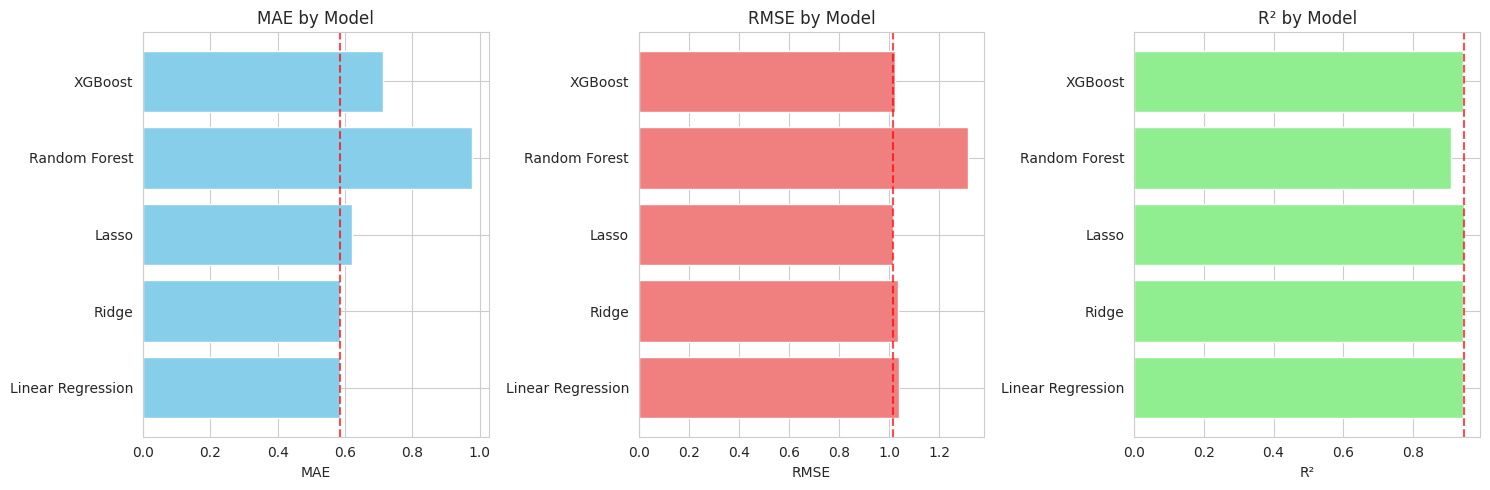

In [16]:
# ============================================================
# 모델 비교 시각화 / Visualize Model Comparison
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['MAE', 'RMSE', 'R²']
colors = ['skyblue', 'lightcoral', 'lightgreen']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    axes[i].barh(results['Model'], results[metric], color=color)
    axes[i].set_xlabel(metric)
    axes[i].set_title(f'{metric} by Model')
    
    # R²는 높을수록 좋음, MAE/RMSE는 낮을수록 좋음
    if metric == 'R²':
        best_val = results[metric].max()
    else:
        best_val = results[metric].min()
    axes[i].axvline(best_val, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

---
## 8. 하이퍼파라미터 튜닝 / Hyperparameter Tuning

In [17]:
# ============================================================
# GridSearchCV를 이용한 하이퍼파라미터 튜닝 (Random Forest)
# Hyperparameter Tuning with GridSearchCV
# ============================================================

# 파라미터 그리드 정의 / Define parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV 실행 / Run GridSearchCV
# ⚠️ 시간이 오래 걸릴 수 있음 / May take a long time
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE),
    param_grid_rf,
    cv=3,
    scoring='neg_mean_squared_error',  # 음수 MSE 사용
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print(f"\n최적 파라미터 / Best parameters: {rf_grid.best_params_}")
print(f"최적 점수 / Best score: {-rf_grid.best_score_:.4f} (MSE)")

# 최적 모델로 평가 / Evaluate with best model
y_pred_rf_tuned = rf_grid.best_estimator_.predict(X_test)
evaluate_regression(y_test, y_pred_rf_tuned, 'Random Forest (Tuned)')

Fitting 3 folds for each of 27 candidates, totalling 81 fits

최적 파라미터 / Best parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}
최적 점수 / Best score: 1.4549 (MSE)

📊 Random Forest (Tuned) 평가 결과 / Evaluation Results
MAE:  0.9598
RMSE: 1.2902
R²:   0.9129


{'mae': 0.9598412777132475,
 'rmse': np.float64(1.290204958354162),
 'r2': 0.9128990147122659}

In [18]:
# ============================================================
# XGBoost 하이퍼파라미터 튜닝 / XGBoost Hyperparameter Tuning
# ============================================================

# 파라미터 그리드 정의 / Define parameter grid
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}

# GridSearchCV 실행 / Run GridSearchCV
xgb_grid = GridSearchCV(
    XGBRegressor(random_state=RANDOM_STATE),
    param_grid_xgb,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)

print(f"\n최적 파라미터 / Best parameters: {xgb_grid.best_params_}")
print(f"최적 점수 / Best score: {-xgb_grid.best_score_:.4f} (MSE)")

# 최적 모델로 평가 / Evaluate with best model
y_pred_xgb_tuned = xgb_grid.best_estimator_.predict(X_test)
evaluate_regression(y_test, y_pred_xgb_tuned, 'XGBoost (Tuned)')

Fitting 3 folds for each of 27 candidates, totalling 81 fits

최적 파라미터 / Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
최적 점수 / Best score: 0.5903 (MSE)

📊 XGBoost (Tuned) 평가 결과 / Evaluation Results
MAE:  0.5376
RMSE: 0.7643
R²:   0.9694


{'mae': 0.5376369115076896,
 'rmse': np.float64(0.764315051817635),
 'r2': 0.9694331645348374}

---
## 9. 피처 중요도 비교 / Feature Importance Comparison

In [19]:
# ============================================================
# 모델별 피처 중요도 비교 / Compare Feature Importance Across Models
# ============================================================

# 피처 중요도 수집 / Collect feature importance
importance_comparison = pd.DataFrame({
    'feature': X.columns,
    'Linear (abs coef)': np.abs(lr_model.coef_),
    'Ridge (abs coef)': np.abs(ridge_model.coef_),
    'Lasso (abs coef)': np.abs(lasso_model.coef_),
    'Random Forest': rf_model.feature_importances_,
    'XGBoost': xgb_model.feature_importances_
})

# 정규화 (비교를 위해) / Normalize for comparison
for col in importance_comparison.columns[1:]:
    max_val = importance_comparison[col].max()
    if max_val > 0:
        importance_comparison[col] = importance_comparison[col] / max_val

print("정규화된 피처 중요도 / Normalized Feature Importance:")
print(importance_comparison.round(3))

정규화된 피처 중요도 / Normalized Feature Importance:
     feature  Linear (abs coef)  Ridge (abs coef)  Lasso (abs coef)  \
0  feature_0              1.000             1.000             1.000   
1  feature_1              0.676             0.676             0.663   
2  feature_2              0.489             0.489             0.474   
3  feature_3              0.339             0.339             0.315   
4  feature_4              0.167             0.166             0.134   
5  feature_5              0.002             0.002             0.000   
6  feature_6              0.001             0.001             0.000   
7  feature_7              0.005             0.005             0.000   
8  feature_8              0.013             0.013             0.000   
9  feature_9              0.014             0.014             0.000   

   Random Forest  XGBoost  
0          1.000    1.000  
1          0.369    0.412  
2          0.236    0.312  
3          0.067    0.131  
4          0.019    0.057  
5    

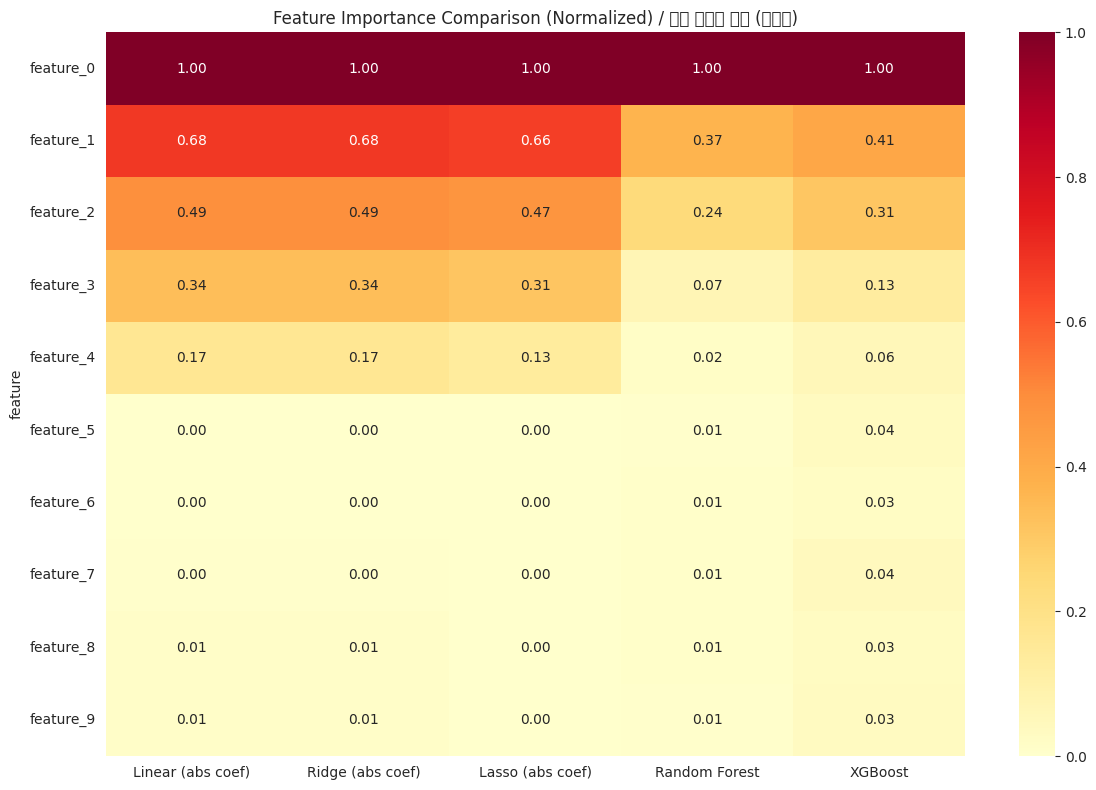

In [20]:
# ============================================================
# 히트맵으로 피처 중요도 비교 / Heatmap of Feature Importance
# ============================================================

plt.figure(figsize=(12, 8))
importance_matrix = importance_comparison.set_index('feature')
sns.heatmap(importance_matrix, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Feature Importance Comparison (Normalized) / 피처 중요도 비교 (정규화)')
plt.tight_layout()
plt.show()

---
## 요약: 회귀 모델 선택 가이드 / Summary: Regression Model Selection Guide

| 모델 | 장점 | 단점 | 적합한 상황 |
|------|------|------|------------|
| **Linear Regression** | 빠름, 해석 용이 | 비선형 관계 학습 불가 | 빠른 베이스라인, 선형 관계 |
| **Ridge** | 다중공선성 완화, 안정적 | 피처 선택 안됨 | 피처 간 상관관계 높을 때 |
| **Lasso** | 피처 선택 효과 | 상관 피처 중 하나만 선택 | 피처 수 줄이고 싶을 때 |
| **Random Forest** | 비선형, 과적합 방지 | 해석 어려움, 느림 | 범용적, 중간 크기 데이터 |
| **XGBoost** | 높은 성능, 정규화 내장 | 튜닝 필요 | 최고 성능 필요할 때 |

In [21]:
print("✅ 회귀 모델 노트북 완료 / Regression models notebook complete!")
print("\n다음 노트북: 02_classification_models.ipynb")
print("Next notebook: 02_classification_models.ipynb")

✅ 회귀 모델 노트북 완료 / Regression models notebook complete!

다음 노트북: 02_classification_models.ipynb
Next notebook: 02_classification_models.ipynb
